In [1]:
import tensorflow as tf

import os
import math
import numpy as np
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import SeparableConv2D,UpSampling2D #
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
import time

from IPython.display import display

In [2]:
tf.config.list_physical_devices(
device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#Get data set
#dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
#data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join("./", "dataset")
root_dir

'./dataset'

In [4]:
crop_size = 300
upscale_factor = 4
low_res_dimension = (300,400,3)
input_size = crop_size // upscale_factor
print(input_size)
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size =(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None
)


valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size =(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None
)

# data_dir = pathlib.Path(root_dir)

# train_ds = data_dir.glob('*/train/*.jpg')
# valid_ds =  data_dir.glob('*/val/*.jpg')

75
Found 296 files belonging to 2 classes.
Using 237 files for training.
Found 296 files belonging to 2 classes.
Using 59 files for validation.


In [5]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

#scale from 0, 255 to 0,1
train_ds= train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)
    

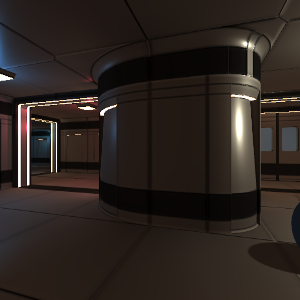

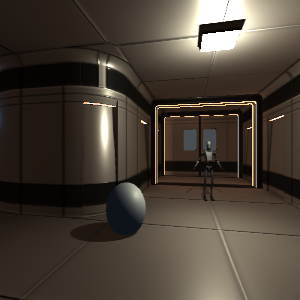

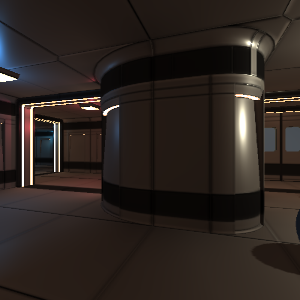

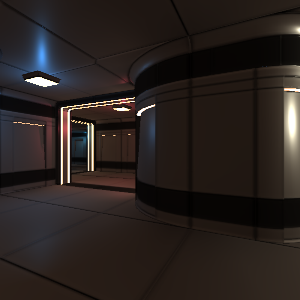

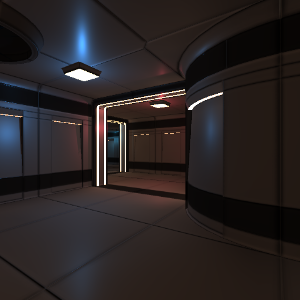

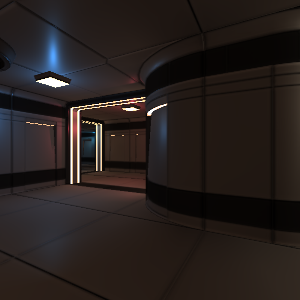

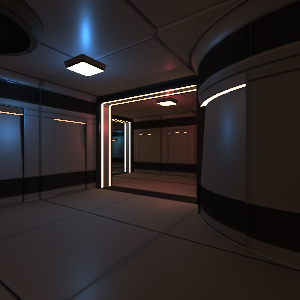

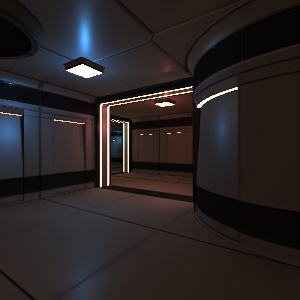

In [6]:
for batch in valid_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [7]:
# dataset = os.path.join(root_dir, "images")
test_path = os.path.join(root_dir, "High")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

In [8]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

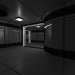

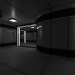

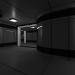

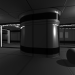

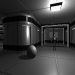

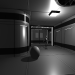

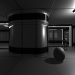

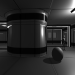

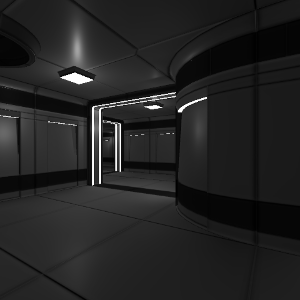

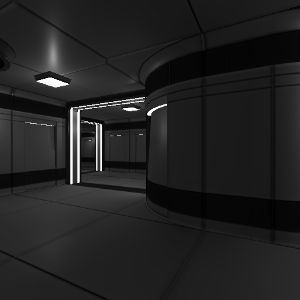

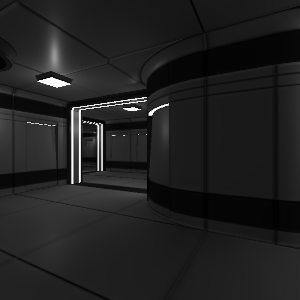

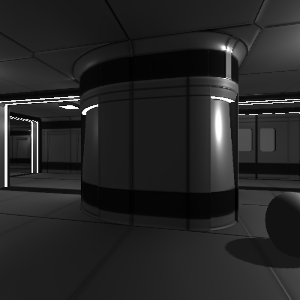

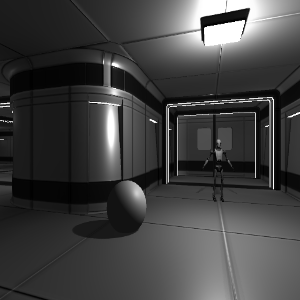

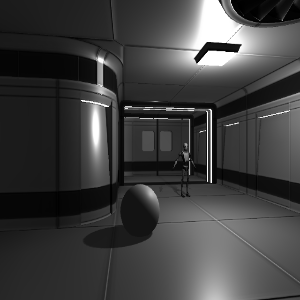

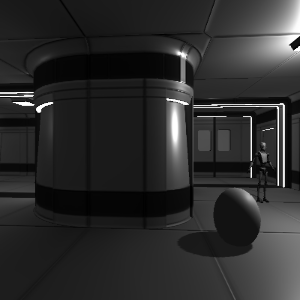

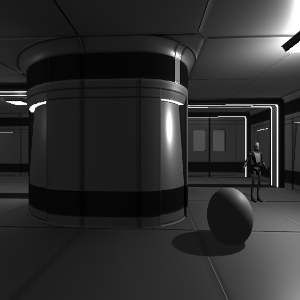

In [9]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [22]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(64, 5, **conv_args)(inputs)
    x = SeparableConv2D(64, 3, **conv_args)(x)
    x = SeparableConv2D(32, 3, **conv_args)(x)
    x = SeparableConv2D(channels * (upscale_factor ** 2), 5, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)    

    return keras.Model(inputs, outputs)

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


In [29]:
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    print(y)
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    t0 = time.perf_counter()
    out = model.predict(input)
    t1 = time.perf_counter()
    print(t1-t0)
    
    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [13]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [23]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
separable_conv2d_6 (Separabl (None, None, None, 64)    4736      
_________________________________________________________________
separable_conv2d_7 (Separabl (None, None, None, 32)    2656      
_________________________________________________________________
separable_conv2d_8 (Separabl (None, None, None, 16)    1328      
_________________________________________________________________
tf.nn.depth_to_space_2 (TFOp (None, None, None, 1)     0         
Total params: 10,384
Trainable params: 10,384
Non-trainable params: 0
_______________________________________________________

Epoch 1/10
30/30 - 2s - loss: 0.0489 - val_loss: 0.0238
Mean PSNR for epoch: 16.10
0.05882199999996374


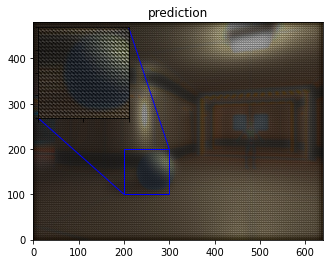

Epoch 2/10
30/30 - 1s - loss: 0.0165 - val_loss: 0.0105
Mean PSNR for epoch: 19.69
Epoch 3/10
30/30 - 1s - loss: 0.0096 - val_loss: 0.0084
Mean PSNR for epoch: 20.60
Epoch 4/10
30/30 - 1s - loss: 0.0082 - val_loss: 0.0073
Mean PSNR for epoch: 21.26
Epoch 5/10
30/30 - 1s - loss: 0.0068 - val_loss: 0.0061
Mean PSNR for epoch: 22.20
Epoch 6/10
30/30 - 1s - loss: 0.0059 - val_loss: 0.0055
Mean PSNR for epoch: 22.54
Epoch 7/10
30/30 - 1s - loss: 0.0053 - val_loss: 0.0051
Mean PSNR for epoch: 22.98
Epoch 8/10
30/30 - 1s - loss: 0.0048 - val_loss: 0.0047
Mean PSNR for epoch: 23.33
Epoch 9/10
30/30 - 1s - loss: 0.0044 - val_loss: 0.0043
Mean PSNR for epoch: 23.73
Epoch 10/10
30/30 - 1s - loss: 0.0041 - val_loss: 0.0040
Mean PSNR for epoch: 24.05


In [24]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# tf.config.set_visible_devices([], 'CPU') # hide the CPU
# tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
# tf.config.get_visible_devices()


epochs = 10

model.compile(
    optimizer=optimizer, loss=loss_fn,
)
with tf.device('/gpu:0'):
    model.fit(
        train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
    )

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

0.0241117000000024
PSNR of low resolution image and high resolution image is 25.3555
PSNR of predict and high resolution is 24.0078
SSIM of predict and high resolution is 0.8322


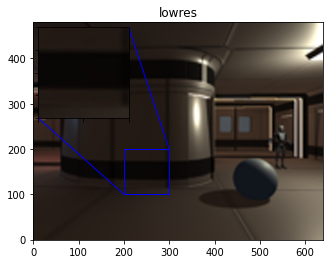

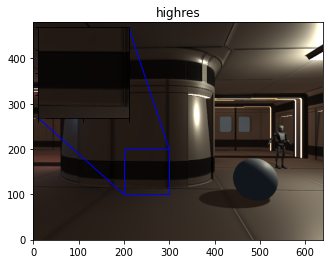

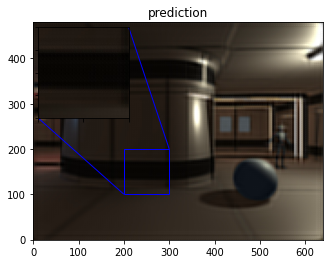

0.07259790000000166
PSNR of low resolution image and high resolution image is 26.0572
PSNR of predict and high resolution is 25.0292
SSIM of predict and high resolution is 0.8419


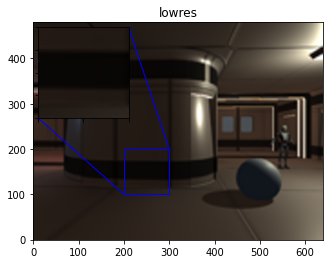

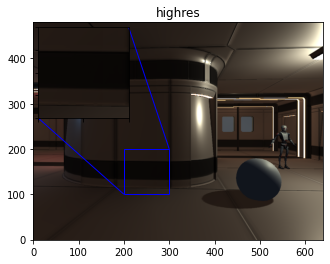

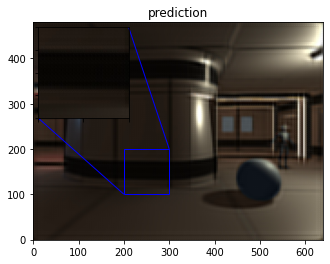

0.023288100000002032
PSNR of low resolution image and high resolution image is 25.8690
PSNR of predict and high resolution is 24.8477
SSIM of predict and high resolution is 0.8377


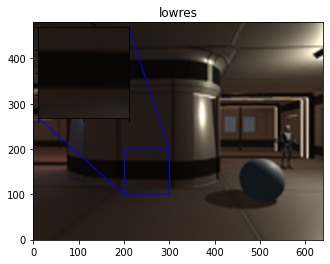

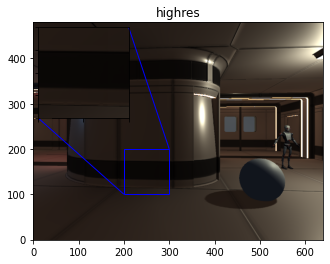

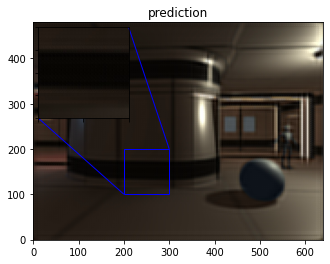

0.023410300000001882
PSNR of low resolution image and high resolution image is 25.7108
PSNR of predict and high resolution is 24.6290
SSIM of predict and high resolution is 0.8400


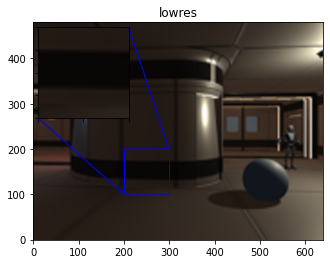

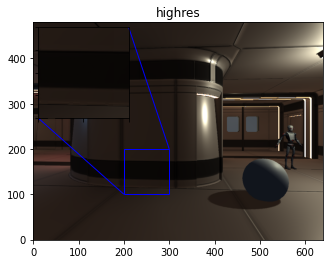

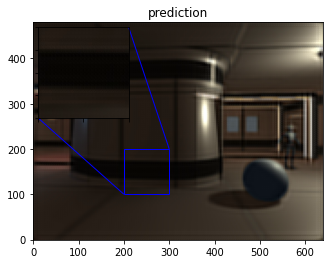

Avg. PSNR of lowres images is 10.2992
Avg. PSNR of reconstructions is 9.8514


In [16]:
import time

total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[56:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
#     t0 = time.perf_counter()
    prediction = upscale_image(model, lowres_input)
#     t1 = time.perf_counter()
#     print(t1-t0)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
    
    ssim1 = tf.image.ssim(predict_img_arr, highres_img_arr, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    
    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    print("SSIM of predict and high resolution is %.4f" % ssim1)
    
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save("model.h5")
model.save_weights('my_model_weights.h5')

<PIL.Image.Image image mode=L size=400x300 at 0x257C90346A0>
0.03977329999997892
PSNR of low resolution image and high resolution image is inf
PSNR of predict and high resolution is 31.5213
SSIM of predict and high resolution is 0.9304


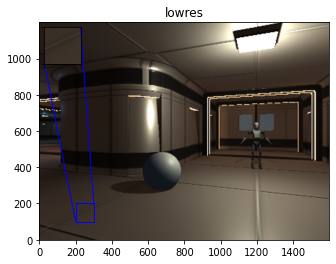

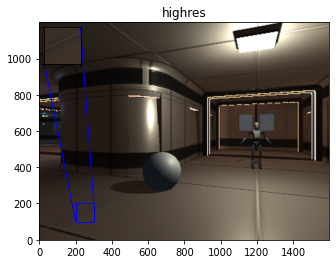

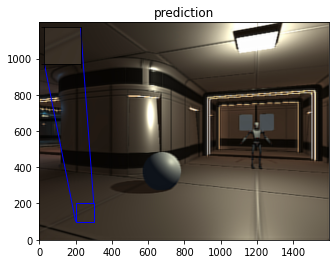

Avg. PSNR of lowres images is inf
Avg. PSNR of reconstructions is 3.1521


In [30]:
import time

total_bicubic_psnr = 0.0
total_test_psnr = 0.0

# for index, test_img_path in enumerate(test_img_paths[56:60]):
img = load_img('./My Images/0002 shotH.png')
lowres_input = img
w = lowres_input.size[0] * upscale_factor
h = lowres_input.size[1] * upscale_factor
highres_img = img.resize((w, h))
# t0 = time.perf_counter()
prediction = upscale_image(model, lowres_input)
# t1 = time.perf_counter()
# print(t1-t0)
lowres_img = lowres_input.resize((w, h))
lowres_img_arr = img_to_array(lowres_img)
highres_img_arr = img_to_array(highres_img)
predict_img_arr = img_to_array(prediction)
bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

ssim1 = tf.image.ssim(predict_img_arr, highres_img_arr, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

total_bicubic_psnr += bicubic_psnr
total_test_psnr += test_psnr

print(
    "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
)
print("PSNR of predict and high resolution is %.4f" % test_psnr)
print("SSIM of predict and high resolution is %.4f" % ssim1)

plot_results(lowres_img, 1, "lowres")
plot_results(highres_img, 1, "highres")
plot_results(prediction, 1, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

tf.keras.preprocessing.image.save_img(
    './Result/out', predict_img_arr, data_format=None, file_format='png', scale=True
)